# Zillow Regression Modeling

#### Tim Keriazes
#### July 27, 2022

### Scenario
Utilizing the 2017 Zillow data set, I set out to build a model that would predict the values of single family homes, examining the correlation between the data points and our target variable (home_value). I will identify critical features that can be used in a regression model to predict home value.

### Project Planning Initial Thoughts:
My initial thoughts were that there would be a direct relationship to the total square footage of the property and its appraised value.
Additionally, I believe there to be a correlation, not just to the number of bedrooms and bathrooms, but also to a ratio of square footage per number of rooms
To explore this I created a new feature:
sqft_room_ratio: 'sqft' / ('bedrooms' + 'bathrooms')

### Executive Summary

    -A more robust combination of cleaned and wrangeled data/features worked best with the regression models.

    -In Summary: Following the evaluation of the different models using my selected features, I found that the best performing model was the Polynomial Regressor with degrees = 2 It performs best when above the median home value.

    -Mean home value = $380,196 
    -Mean square footage = 1774 
    -Mean Bedrooms = 3 
    -Mean Bathrooms = 2

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

#functions
import wrangle as wr

warnings.filterwarnings("ignore")

#evaluate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from statsmodels.formula.api import ols
import sklearn.preprocessing

#feature engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#### With my wrangle_zillow function I was able to optimize data types, clean the data, handle outliers, and do some basic feature engineering


In [ ]:
#manually trimmed the data so as to remove the outliers skewing the data
#homes with more that 6 bedrooms, more than 6 bathrooms, with less than 15000 sq ft, and less than 1500000 taxvaluedollarcnt

In [2]:
df = wr.wrangle_zillow()

In [3]:
train, validate, test = wr.split(df, stratify_by=None)

In [4]:
train.shape, validate.shape, test.shape

((1153611, 12), (494406, 12), (412005, 12))

#### Split and Scale

In [5]:
train_scaled, validate_scaled, test_scaled = wr.scale_zillow(train, validate, test)

In [6]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((1153611, 12), (494406, 12), (412005, 12))

#### Explore

<AxesSubplot:>

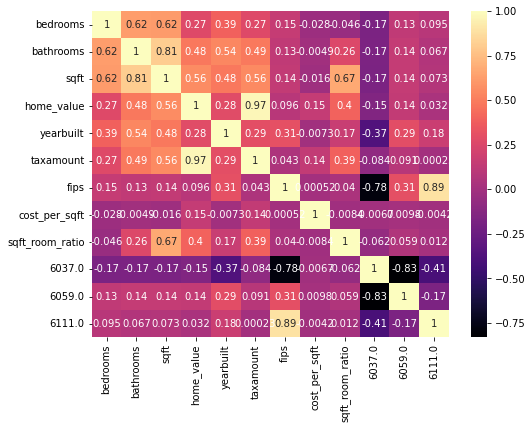

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(train_scaled.corr(), cmap='magma', annot=True)

### Heat Map Takeaways:

Correlations between bedrooms, bathrooms, sqft, and sqft_room_ratio

In [8]:
def jointplot(x, y, df):
    '''
    jointplot will take in a feature("x") and a target("y") 
    and plot a corresponding scatter and distribution.
    '''
    
    p = sns.jointplot(x=x, y=y, data=df, kind="hex", color="mediumslateblue")
    
    return p

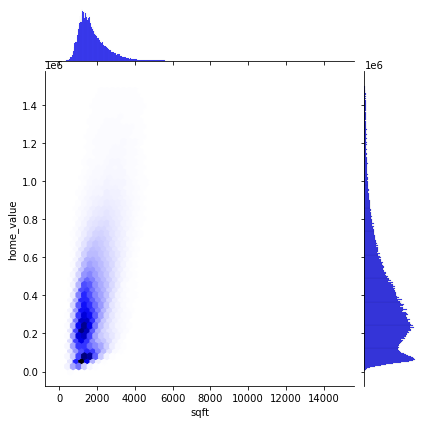

In [9]:
sns.jointplot(x='sqft', y='home_value', data=df, kind="hex", color="blue")

This jointplot tells me a majority of homes are in the
bottom 20% of square feet and bottom 45% of home_value.

### Hypothesis Testing


Tested Hypotheses

    1. Ho: No correlation between square footage and home value.

       Ha: There is a correlation between square footage and home value.


    2. Ho: No correlation between number of bathrooms and home value.

       Ha: There is a correlation between bathrooms and home value.


    3. Ho: No correlation between number of bedrooms and home value.

       Ha: There is a correlation between bathrooms and home value.


    4. Ho: No correlation between square footage per room ratio and home value.

       Ha: There is a correlation between square footage per room ratio and home value.

In [ ]:
#results can be found in my zillow_regression_project_notebook

### Evaluate Data

In [10]:
train

,bedrooms,bathrooms,sqft,home_value,yearbuilt,taxamount,fips,cost_per_sqft,sqft_room_ratio,6037.0,6059.0,6111.0
1088045,3,2.0,1068,47535,1959,567.16,6111.0,44.51,213.60,0,0,1
1457900,3,2.0,1542,847768,1941,9306.24,6037.0,549.78,308.40,1,0,0
115397,3,2.5,2174,306182,1964,3762.70,6059.0,140.84,395.27,0,1,0
506301,3,2.0,1359,156270,1973,1675.46,6111.0,114.99,271.80,0,0,1
641634,3,2.0,1200,79986,1977,1292.17,6037.0,66.66,240.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
463215,4,3.0,2029,328179,1994,3465.88,6111.0,161.74,289.86,0,0,1
1793012,3,1.0,1083,217072,1944,2819.76,6037.0,200.44,270.75,1,0,0
136986,3,2.0,2463,438091,1956,5110.96,6059.0,177.87,492.60,0,1,0
988610,3,2.5,1750,71543,1963,1104.14,6059.0,40.88,318.18,0,1,0


In [11]:
#separate target from features that will be used and scale

In [12]:
X_train = train.drop(columns=['home_value','taxamount','fips','cost_per_sqft'])
X_validate = validate.drop(columns=['home_value','taxamount','fips','cost_per_sqft'])
X_test = test.drop(columns=['home_value','taxamount','fips','cost_per_sqft'])
y_train = train.home_value
y_validate = validate.home_value
y_test = test.home_value

In [13]:
X_train

,bedrooms,bathrooms,sqft,yearbuilt,sqft_room_ratio,6037.0,6059.0,6111.0
1088045,3,2.0,1068,1959,213.60,0,0,1
1457900,3,2.0,1542,1941,308.40,1,0,0
115397,3,2.5,2174,1964,395.27,0,1,0
506301,3,2.0,1359,1973,271.80,0,0,1
641634,3,2.0,1200,1977,240.00,1,0,0
...,...,...,...,...,...,...,...,...
463215,4,3.0,2029,1994,289.86,0,0,1
1793012,3,1.0,1083,1944,270.75,1,0,0
136986,3,2.0,2463,1956,492.60,0,1,0
988610,3,2.5,1750,1963,318.18,0,1,0


In [14]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_train)

train_mms = mms.transform(X_train)

In [15]:
#scaled back into df
X_train_scaled = pd.DataFrame(train_mms, columns=list(X_train.columns))

In [16]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_validate)

validate_mms = mms.transform(X_validate)

In [17]:
#scaled back into df
X_validate_scaled = pd.DataFrame(validate_mms, columns=list(X_validate.columns))

In [18]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_test)

test_mms = mms.transform(X_test)

In [19]:
#scaled back into df
X_test_scaled = pd.DataFrame(test_mms, columns=list(X_test.columns))

In [20]:
X_test_scaled

,bedrooms,bathrooms,sqft,yearbuilt,sqft_room_ratio,6037.0,6059.0,6111.0
0,0.6,0.363636,0.093689,0.750000,0.043249,0.0,1.0,0.0
1,0.4,0.272727,0.083451,0.779412,0.050089,0.0,1.0,0.0
2,0.4,0.272727,0.103927,0.857843,0.062373,0.0,1.0,0.0
3,0.4,0.272727,0.067354,0.632353,0.040431,1.0,0.0,0.0
4,0.4,0.090909,0.073079,0.661765,0.054837,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
412000,0.6,0.363636,0.145215,0.745098,0.067031,0.0,1.0,0.0
412001,0.2,0.090909,0.083047,0.686275,0.083090,1.0,0.0,0.0
412002,0.6,0.272727,0.084529,0.789216,0.042275,1.0,0.0,0.0
412003,0.2,0.090909,0.048427,0.607843,0.048472,1.0,0.0,0.0


### Feature Selection/Confirmation
    -f_feature
    -rfe_feature

In [21]:
# from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

In [23]:
f_feature

['bathrooms', 'sqft', 'yearbuilt', 'sqft_room_ratio']

In [24]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

In [25]:
rfe_feature

['bathrooms', '6037.0', '6059.0', '6111.0']

## Modeling
    -compute and evaluate predicted values
    -compare models with train, move forward with best for validate
    -compute and evaluate test
    
    

In [26]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [27]:
#preview
y_train.head()

,home_value
1088045,47535
1457900,847768
115397,306182
506301,156270
641634,79986


In [28]:
# 1. compute pred_median
home_value_baseline_median = y_train['home_value'].median()
y_train['home_value_baseline_median'] = home_value_baseline_median
y_validate['home_value_baseline_median'] = home_value_baseline_median

# 2. compute pred_mean
home_value_baseline_mean = y_train['home_value'].mean()
y_train['home_value_baseline_mean'] = home_value_baseline_mean
y_validate['home_value_baseline_mean'] = home_value_baseline_mean

#check to see which is better
y_train.head()

,home_value,home_value_baseline_median,home_value_baseline_mean
1088045,47535,318089.0,380196.833903
1457900,847768,318089.0,380196.833903
115397,306182,318089.0,380196.833903
506301,156270,318089.0,380196.833903
641634,79986,318089.0,380196.833903


In [29]:
# 3. RMSE of hv_pred_median
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_baseline_median) ** (0.5)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_baseline_median) ** (0.5)

print(f"""
      BASELINE:
      
      RMSE using Median
      Train/In-Sample: {round(rmse_train, 2)}
      Validate/Out-of-Sample: {round(rmse_validate, 2)}
        """)


      BASELINE:
      
      RMSE using Median
      Train/In-Sample: 279765.61
      Validate/Out-of-Sample: 279423.34
        


### Train / Validate



In [30]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.home_value)

# predict train
y_train['home_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm)**(0.5)

# predict validate
y_validate['home_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: {round(rmse_train_lm, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: 222808.75
    Validation/Out-of-Sample: 223201.38



In [31]:
# create the model object

lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.home_value)

# predict train
y_train['home_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.home_value, y_train.home_value_pred_lars)**(0.5)

# predict validate
y_validate['home_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lars)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

    RMSE for LassoLars
    
    Training/In-Sample: {round(rmse_train_lars, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

    RMSE for LassoLars
    
    Training/In-Sample: 222941.29
    Validation/Out-of-Sample: 223345.81



In [32]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.home_value)

# predict train
y_train['home_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.home_value, y_train.home_value_pred_glm)**(0.5)

# predict validate
y_validate['home_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_glm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
    RMSE for TweedieRegressor (GLM)
    power=1, alpha=0
    
    Training/In-Sample: {round(rmse_train_glm, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

                RMSE for LassoLars
                
                Training/In-Sample: 222941.29
                Validation/Out-of-Sample: 223345.81
    
    RMSE for TweedieRegressor (GLM)
    power=1, alpha=0
    
    Training/In-Sample: 272784.56
    Validation/Out-of-Sample: 272460.67



In [33]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [34]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.home_value)

# predict train
y_train['home_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm2)**(0.5)

# predict validate
y_validate['home_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm2)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: {round(rmse_train_lm2, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

                RMSE for LassoLars
                
                Training/In-Sample: 222941.29
                Validation/Out-of-Sample: 223345.81
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 272784.56
                Validation/Out-of-Sample: 272460.67
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: 218941.54
    Validation/Out-of-Sample: 219469.22



In [35]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf3.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf3.transform(X_validate)
X_test_degree3 = pf3.transform(X_test)

In [36]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.home_value)

# predict train
y_train['home_value_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_lm3 = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm3)**(0.5)

# predict validate
y_validate['home_value_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_lm3 = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm3)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: {round(rmse_train_lm2, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}
                
    
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: {round(rmse_train_lm3, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm3, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

                RMSE for LassoLars
                
                Training/In-Sample: 222941.29
                Validation/Out-of-Sample: 223345.81
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 272784.56
                Validation/Out-of-Sample: 272460.67
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: 218941.54
                Validation/Out-of-Sample: 219469.22
                
    
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: 21

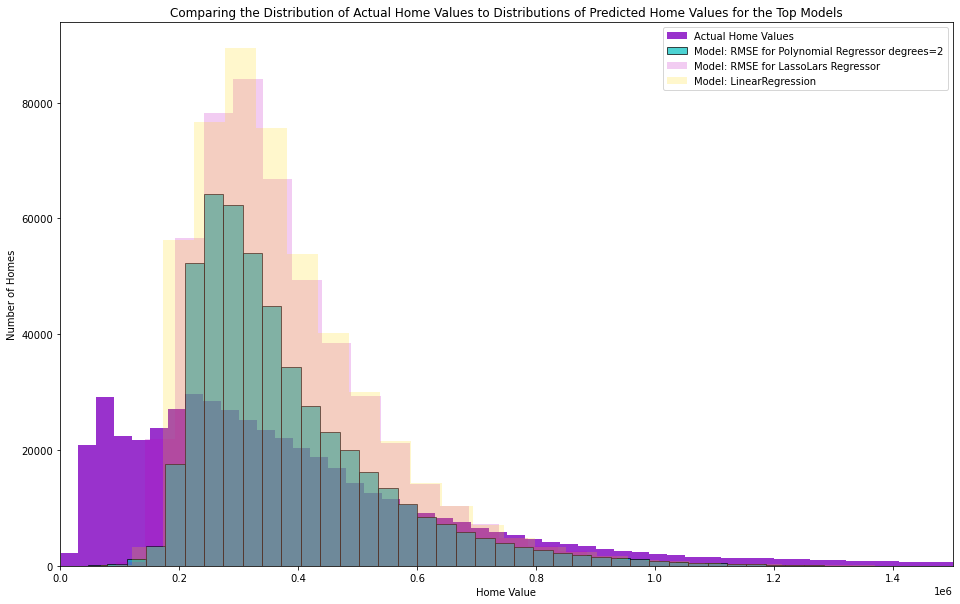

In [37]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.home_value, color='darkorchid', alpha=1, bins=50, label="Actual Home Values")
plt.hist(y_validate.home_value_pred_lm2, color='c', alpha=.7, bins=50, label="Model: RMSE for Polynomial Regressor degrees=2", ec='black')
#plt.hist(y_validate.home_value_pred_lm3, color='chartreuse', alpha=.2, bins=50, label="Model: RMSE for Polynomial Regressor degrees=3")
plt.hist(y_validate.home_value_pred_lars, color='m', alpha=.2, bins=50,label="Model: RMSE for LassoLars Regressor ")
plt.hist(y_validate.home_value_pred_lm, color='gold', alpha=.2, bins=50,label="Model: LinearRegression")
#plt.hist(y_validate.home_value_pred_lars, color='red', alpha=.5, bins=50, label="Model: RMSE for Tweedie Regressor")
plt.xlim(0, 1500000)
plt.xlabel("Home Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Home Values to Distributions of Predicted Home Values for the Top Models")
plt.legend()
plt.show()

## Best model based on the RMSE evaluation was the 2nd degree Polynomial Regressor model

## Test

In [38]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['home_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.home_value, y_test.home_value_pred_lm2)**(0.5)

print(f"""
    RMSE for Polynomial Regressor degrees=2
    
    Test/Out-of-Sample Performance: {round(rmse_test, 2)}
""")


    RMSE for Polynomial Regressor degrees=2
    
    Test/Out-of-Sample Performance: 219647.25



## Summary
### Following the evaluation of the different models using my selected features, I found that the best performing model was the Polynomial Regressor with degrees = 2

### Looks like it performs best when above the median home value, and much worse below the median value

### Next Steps: look at how the data is skewed, and find a way to either scale it better to reduce that skew, or adjust the outliers towards the higher end of the data set to account for the majority of the homes on the lower end in order to improve model performance.